In [2]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn

from torch.distributions import MultivariateNormal

import flows
import nn as flows_nn

In [3]:
%env CUDA_VISIBLE_DEVICES=1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env: CUDA_VISIBLE_DEVICES=1


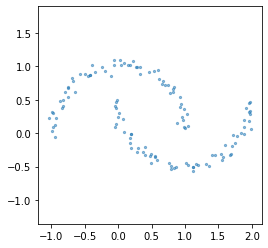

In [4]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

# d = DatasetMoons()
d = DatasetMoons()
# d = DatasetSIGGRAPH()

x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');


In [5]:
# construct a model

dim = 2
prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))

# RealNVP - AffineHalfFlow(dim=dim)

# NICE - AffineHalfFlow(dim=dim, scale=False)

# MAF - MAF(dim=dim)

# IAF - IAF(dim=dim)

# norms - ActNorm(dim=dim)

# Glow - Invertible1x1Conv(dim=dim)

# Neural splines, coupling - NSF_CL(dim=dim)

# Neural splines, autoregressive - NSF_AR(dim=dim)

# flows = [choices[np.random.randint(len(choices))](dim=dim) for _ in range(10)]
list_flows = [flows.NSF_AR(dim=dim, base_network=flows_nn.MLP),
             flows.InvertiblePermutation(dim=dim),
             flows.NSF_AR(dim=dim, base_network=flows_nn.MLP)
        ]

# construct the model
model = flows.NormalizingFlowModel(prior, list_flows).to(device)


In [6]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  9528


In [7]:
model.train()
for k in range(10000):
    x = d.sample(128)
    
    zs, prior_logprob, log_det = model(x.to(device))
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())


600.5470581054688
550.353515625
490.70111083984375
409.6473388671875
372.9303894042969
327.0672912597656
304.3396301269531
254.61158752441406
238.51693725585938
220.95571899414062
192.67233276367188
193.81495666503906
180.23287963867188
159.46214294433594
163.79244995117188
140.7099151611328
140.1486358642578
128.76760864257812
131.213134765625
127.50109100341797
94.73365020751953
111.99098205566406
101.04820251464844
106.36070251464844
86.74339294433594
107.13131713867188
91.57112884521484
95.9094009399414
98.90695190429688
90.44111633300781
101.24462890625
108.05332946777344
77.77433776855469
93.42124938964844
88.88137817382812
76.74107360839844
65.8669662475586
83.7867431640625
83.03303527832031
75.9139404296875
89.62024688720703
95.00641632080078
75.19750213623047
77.3305892944336
77.52672576904297
91.041015625
74.90380096435547
73.33106994628906
74.01480865478516
81.80780029296875
79.93075561523438
78.4981918334961
87.97869873046875
69.16326141357422
80.3033447265625
78.3094329833

Text(0.5, 1.0, 'z -> x')

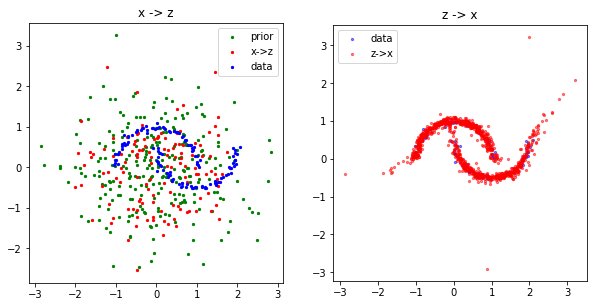

In [8]:
model.eval()

x = d.sample(128)
z, prior_logprob, log_det = model(x)

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

z = model.sample(128*8)
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')